# Chapter 3 Time series Decomposition

In [197]:
from tsdata.raw import available_data, load_data
import pandas as pd
import numpy as np
# plotting
import seaborn as sns
from plotnine import (ggplot, geom_line, xlab, ylab, ggtitle, aes, theme, geom_density,
                      facet_wrap,  geom_point, scale_color_manual, scale_alpha_manual)


When we decompose a time series into components, we usually combine the **trend and cycle** into a single trend-cycle component (often just called the **trend** for simplicity). Thus we can think of a time series as comprising three components: 
- trend-cycle component
- seasonal component
- remainder component

In this chapter, we consider the most common methods for extracting these components from a time series.

 Often this is done to help 
 
- improve understanding of the time series
- improve forecast accuracy.

## Transformations and Adjustments

Here, we deal with four kinds of adjustments: 
- calendar adjustments
- population adjustments
- inflation adjustments 
- mathematical transformations

### Calendar adjustments

Example: Some months have more days in the month, this can be dealt with by removing the variation by computing average sales per trading day in each month, rather than total sales in the month. Then we effectively remove the calendar variation.

### Population Adjustments

Example: hospital beds per thousands of population



In [ ]:
global_economy_df = load_data("global_economy")

australia_economy_df = (global_economy_df[global_economy_df.Country == "Australia"]
 .assign(gdp_per_capita = lambda df: df.GDP / df.Population)
)
(ggplot(australia_economy_df) +
    aes(x='Year', y='gdp_per_capita') +
    geom_line(color="#336699", alpha=0.6) +
    geom_point(color="#336699", alpha=0.6) +
    ylab("$US") +
    ggtitle("GDP Per Capita for Australia") +
    theme(figure_size=(12, 6))
)

### Inflation adjustments

Data which are affected by the value of money are best adjusted before modelling. For example, the average cost of a new house will have increased over the last few decades due to inflation. A $200,000 house this year is not the same as a $200,000 house twenty years ago. For this reason, financial time series are usually adjusted so that all values are stated in dollar values from a particular year. For example, the house price data may be stated in year 2000 dollars.

To make these adjustments, a price index is used.

- $z_t$ denotes the price index and 
- $y_t$ denotes the original house price in year $t$

Then

$x_t = \frac{y_t}{z_t} * z_{2000}$ gives the adjusted price at year 2000

Consumer price index - It measures the total relative price change of goods and services used by resident households for private (non-production) consumption.

In [ ]:
aus_retail_df = (load_data("aus_retail")
 .assign(Date = lambda df: pd.to_datetime(df.Month, format="%Y %b"))
 .assign(Year = lambda df: df.Date.dt.year, Month = lambda df: df.Date.dt.month)
)

news_books_retail_turnover_df = (aus_retail_df[aus_retail_df.Industry == "Newspaper and book retailing"]
 .groupby(['State', 'Year'])[['Turnover']]
 .sum('Turnover')
 .reset_index()
)

(ggplot(news_books_retail_turnover_df) +
    aes(x='Year', y='Turnover', color='State') +
    geom_line() +
    ggtitle("Turnover for Newspapers and Books for all states of Australia")
)

We can use the global_economy dataframe to get the CPI

In [ ]:
(
news_books_retail_turnover_df.merge(
    global_economy_df[global_economy_df.Code == "AUS"],
    how='left',
    on='Year'
)
# assign adjusted w.r.t. inflation Turnover
.assign(
    AdjustedTurnover=lambda df: df.Turnover / df.CPI * 100
)[['Year', 'State', 'Turnover', 'AdjustedTurnover']]
.melt(id_vars=['Year', 'State'])
.head()
)

In [ ]:
(news_books_retail_turnover_df.merge(
    global_economy_df[global_economy_df.Code == "AUS"],
    how='left',
    on='Year'
).assign(
    AdjustedTurnover=lambda df: 100 * df.Turnover / df.CPI
)[['Year', 'State', 'Turnover', 'AdjustedTurnover']].melt(id_vars=['Year', 'State'])
.pipe(ggplot) +
    aes(x='Year', y='value', color='variable') +
    geom_line() +
    facet_wrap('State', scales='free', ncol=2) +
    xlab("Year") +
    ylab("Turnover") +
    ggtitle("Turnover for Newspapers and Books for all states of Australia") +
    theme(legend_position='bottom', figure_size=(12, 6))
)

### Mathematical Transformations

- $log_{10}$
- Power transformations

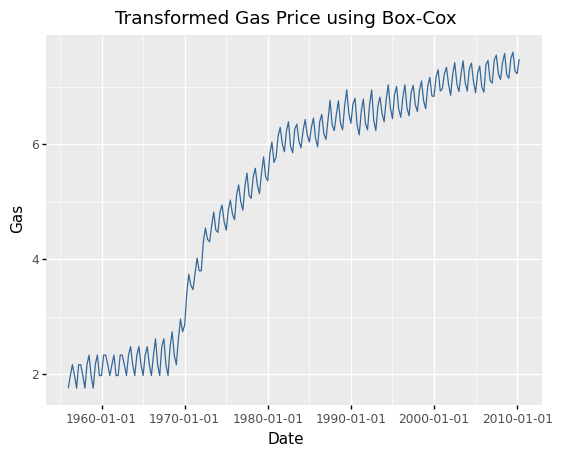

<ggplot: (323599746)>

In [229]:
from statsmodels.base.transform import BoxCox

aus_production_df = load_data("aus_production").assign(
    Date=lambda df: pd.to_datetime(df.Quarter.str.replace(" ", "-"))
)

# from statsmodels.base.transform import transform_boxcox
bc = BoxCox()

(aus_production_df.assign(
    GasTransformed=lambda df: bc.transform_boxcox(
        x=df.Gas, method='guerrero'
    )[0]
).pipe(ggplot) +
    aes(x='Date', y='GasTransformed') +
    geom_line(color="#336699") +
    ylab("Gas") +
    ggtitle("Transformed Gas Price using Box-Cox")
)

In [234]:
from scipy.stats import boxcox

_, max_lambda = boxcox(x=aus_production_df.Gas)
max_lambda

0.4374315279941498

## 3.2 Time Series Components

If we assume an additive decomposition, then we can write

$$y_t=S_t + T_t+R_t$$

Where T_t is the trend-cycle component, $R_t$ is the remaining part.

Alternatively, a multiplicative decomposition would be written as

$$
y_t = S_t \times T_t \times R_t
$$

The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate.

**An alternative to using a multiplicative decomposition is to first transform the data until the variation in the series appears to be stable over time, then use an additive decomposition.**

When a log transformation has been used, this is equivalent to using a multiplicative decomposition (logarithms turn multiplication to addition).

### Example: Employment in the US retail sector

In [ ]:
us_employment_df = load_data("us_employment").assign(
    Date=lambda df: pd.to_datetime(df.Month, format="%Y %b")
).assign(
    Year=lambda df: df.Date.dt.year,
    Month=lambda df: df.Date.dt.month
).set_index('Date')


retail_df = us_employment_df[
    (us_employment_df.Year >= 1990) &
    (us_employment_df.Title == "Retail Trade")
]

retail_df.Employed.plot()

In [ ]:
from statsmodels.tsa.seasonal import STL
from statsmodels.datasets import co2
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (16, 8)


register_matplotlib_converters()

# Seasonal and Trend decomposition using LOESS
res = STL(retail_df.Employed).fit()
res.plot()
fig = plt.show()

res

In [ ]:

(pd.DataFrame({
    'trend': res.trend,
    'employed': res.observed
})
.reset_index()
.melt(id_vars='Date')
.pipe(ggplot) +
    aes(x='Date', y='value', color='variable') +
    geom_line() +
    scale_color_manual(values=["#336699", "orange"]) +
    scale_alpha_manual(values=[0.2, 0.02]) +
    theme(figure_size=(12, 6)) +
    ylab("Trend and Observed Series") +
    ggtitle("Trend and Observed Series")
)

### Seasonally adjusted data

In [ ]:
(pd.DataFrame({
    'seasonaly_adjusted': res.observed - res.seasonal,
    'employed': res.observed
})
.reset_index()
.melt(id_vars='Date')
.pipe(ggplot) +
    aes(x='Date', y='value', color='variable') +
    geom_line() +
    scale_color_manual(values=["#336699", "orange"]) +
    scale_alpha_manual(values=[0.2, 0.02]) +
    theme(figure_size=(12, 6)) +
    ylab("Trend and Observed Series") +
    ggtitle("Trend and Observed Series")
)

If the variation due to seasonality is not of primary interest, the seasonally adjusted series can be useful. For example, monthly unemployment data are usually seasonally adjusted in order to highlight variation due to the underlying state of the economy rather than the seasonal variation. An increase in unemployment due to school leavers seeking work is seasonal variation, while an increase in unemployment due to an economic recession is non-seasonal. Most economic analysts who study unemployment data are more interested in the non-seasonal variation. Consequently, employment data (and many other economic series) are usually seasonally adjusted.

**If the purpose is to look for turning points in a series, and interpret any changes in direction, then it is better to use the trend-cycle component rather than the seasonally adjusted data.**

### Moving Average

### Classical Decomposition

In [ ]:
trend_cycle = retail_df.Employed.rolling(center=True, window=12).mean()

detrended = ((retail_df.Employed - trend_cycle)
 .reset_index()
 .assign(month = lambda df: df.Date.dt.month)
)

seasonal_ = detrended.groupby("month").mean()
# seasonal component is just the average of all the different months
seasonal = detrended.merge(seasonal_, on='month').set_index("Date").Employed_y

remainder = retail_df.Employed - trend_cycle - seasonal
# remainder.plot()


(pd.DataFrame({
    'actual': retail_df.Employed,
    'seasonal': seasonal,
    'remainder': remainder,
    'trend_cycle': trend_cycle
})
.reset_index()
.melt(id_vars='Date')
.pipe(ggplot) +
    aes(x='Date', y='value') +
    geom_line() +
    # geom_point() +
    facet_wrap('variable', scales='free', ncol=1) +
    theme(figure_size=(18, 8)) +
    ggtitle("Classical Decomposition")
)

While classical decomposition is still widely used, it is not recommended, as there are now several much better methods. Some of the problems with classical decomposition are summarised below.

The estimate of the trend-cycle is unavailable for the first few and last few observations. For example, if   m=12,
* there is no trend-cycle estimate for the first six or the last six observations. Consequently, there is also no estimate of the remainder component for the same time periods.
* The trend-cycle estimate tends to over-smooth rapid rises and falls in the data.
* Classical decomposition methods assume that the seasonal component repeats from year to year. For many series, this is a reasonable assumption, but for some longer series it is not. For example, electricity demand patterns have changed over time as air conditioning has become more widespread. In many locations, the seasonal usage pattern from several decades ago had its maximum demand in winter (due to heating), while the current seasonal pattern has its maximum demand in summer (due to air conditioning). Classical decomposition methods are unable to capture these seasonal changes over time.
Occasionally, the values of the time series in a small number of periods may be particularly unusual. For example, the monthly air passenger traffic may be affected by an industrial dispute, making the traffic during the dispute different from usual. The classical method is not robust to these kinds of unusual values.

### Other methods used by statistics agencies

#### X-11 - What package to use in python for that?
#### SEATS - What package to use in python for that?
#### STL Decomposition

###### Advantages of STL

* Unlike SEATS and X-11, STL will handle any type of seasonality, not only monthly and quarterly data.
* The seasonal component is allowed to change over time, and the rate of change can be controlled by the user.
* The smoothness of the trend-cycle can also be controlled by the user.
* It can be robust to outliers (i.e., the user can specify a robust decomposition), so that occasional unusual observations will not affect the estimates of the trend-cycle and seasonal components. They will, however, affect the remainder component.

##### Disadvantages

 * it does not handle trading day or calendar variation automatically
 * it only provides facilities for additive decompositions


 ##### Parameters using STL are 
 * trend-cycle window trend(window = ?)
 * seasonal window season(window = ?)
 
 These control how rapidly the trend-cycle and seasonal components can change.



In [ ]:
# STL in Python
from statsmodels.tsa.seasonal import STL

stl = STL(retail_df.Employed, seasonal=13)

res = stl.fit()
fig = res.plot()


## Exercises


In [ ]:
global_economy_df

In [ ]:
# Consider the GDP information in global_economy. Plot the GDP per capita for each country over time. 
# Which country has the highest GDP per capita? 
# How has this changed over time?

global_economy_df['GDP_Per_Capita'] = (global_economy_df
 .groupby('Country', group_keys=False)
 .apply(lambda df: df.GDP / df.Population)
)

last_year = global_economy_df.Year.max()

top_10_countries = global_economy_df[
    global_economy_df.Year == last_year
].sort_values(by='GDP_Per_Capita', ascending=False).Country[:10]


In [ ]:

(global_economy_df[
  global_economy_df.Country.isin(top_10_countries)
 ]
 .pipe(ggplot) +
    aes(x='Year', y='gdppc', color='Country') +
    geom_line() +
    theme(figure_size=(12, 6)) +
    ggtitle("top 20 Countries by GDP per capita") +
    ylab("GDP Per Capita")
)

In [ ]:
# take top 20
global_economy_df[
  (global_economy_df.Country.isin(top_10_countries)) & (global_economy_df.Year == 2017)
 ].sort_values(by='GDPPC').assign(GDPPC = lambda df: df.GDPPC.round(4))

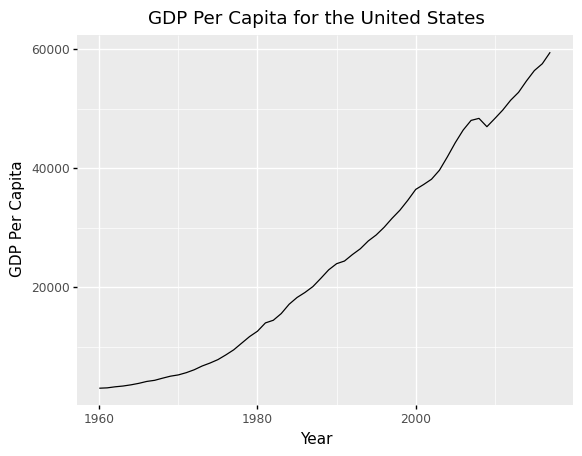

<ggplot: (317680954)>

In [173]:
# 2. For each of the following series, make a graph of the data. If transforming seems appropriate, do so and describe the effect.

us_economy_df = global_economy_df[global_economy_df.Code == "USA"]
(us_economy_df
 .assign(GDP_Per_Capita = lambda df: df.GDP / df.Population)
 .pipe(ggplot) +
    aes(x='Year', y='GDP_Per_Capita') +
    geom_line() +
    ylab("GDP Per Capita") +
    ggtitle("GDP Per Capita for the United States")
)

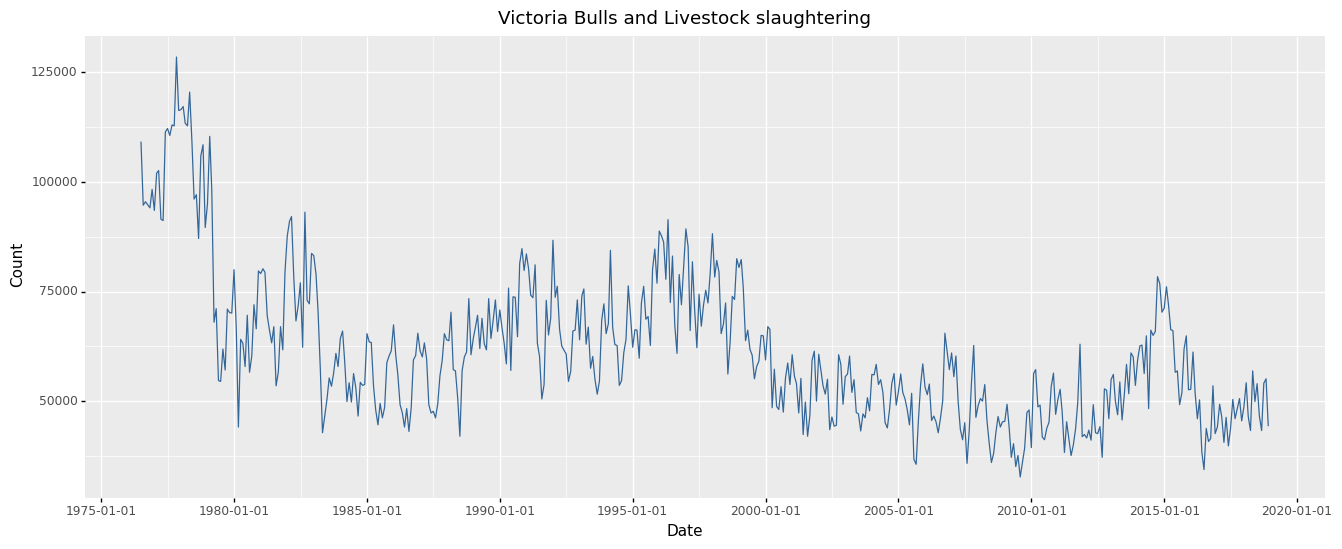

<ggplot: (313735202)>

In [181]:
aus_livestock_df = load_data("aus_livestock").assign(
    Date=lambda df: pd.to_datetime(df.Month, format="%Y %b")
).assign(
    Year=lambda df: df.Date.dt.year,
    Month=lambda df: df.Date.dt.month
)

bulls_aus_livestock_df = aus_livestock_df[aus_livestock_df.Animal == "Bulls, bullocks and steers"]
victoria_bulls_df = bulls_aus_livestock_df[bulls_aus_livestock_df.State == "Victoria"]
(ggplot(victoria_bulls_df) +
    aes(x='Date', y='Count') +
    geom_line(color="#336699") +
    ggtitle("Victoria Bulls and Livestock slaughtering") +
    theme(figure_size=(16, 6))
)

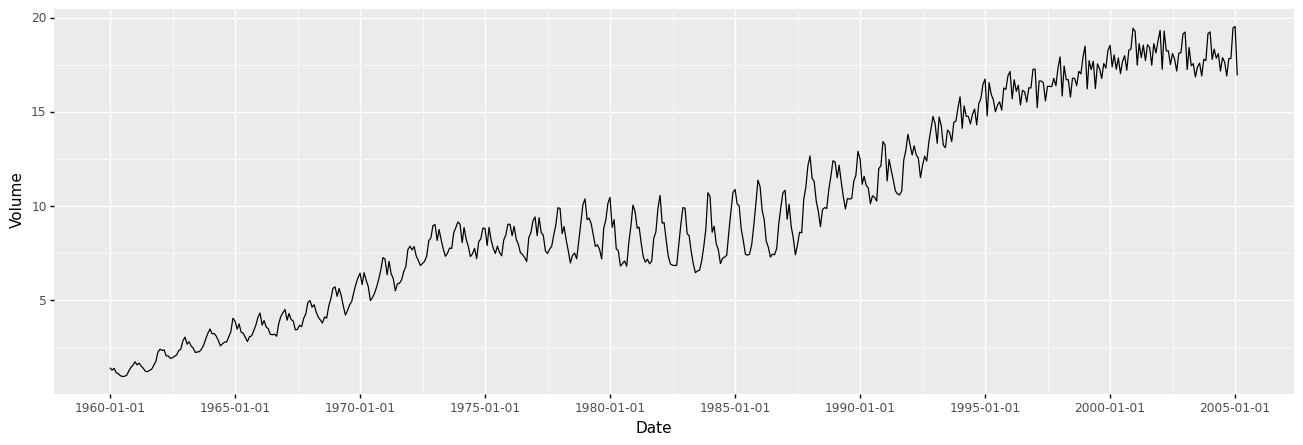

<ggplot: (314535741)>

In [190]:
# 3. 

canadian_gas_df = load_data("canadian_gas").assign(
    Date=lambda df: pd.to_datetime(df.Month, format="%Y %b")
).assign(
    Year=lambda df: df.Date.dt.year,
    Month=lambda df: df.Date.dt.month
)



ggplot(canadian_gas_df) + aes(x='Date', y='Volume') + geom_line() + theme(figure_size=(16,5))

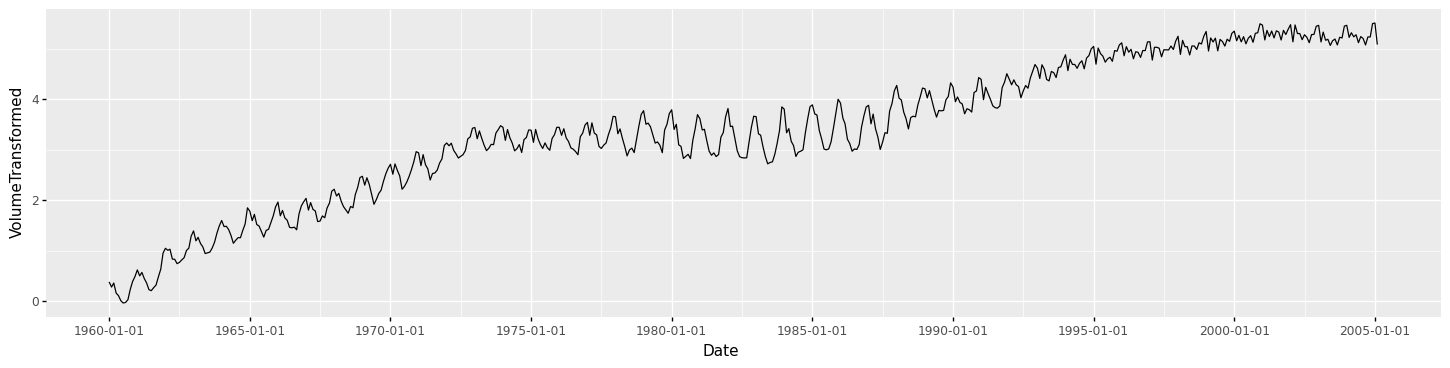

<ggplot: (318589088)>

In [208]:
from statsmodels.base.transform import BoxCox


# from statsmodels.base.transform import transform_boxcox

canadian_gas_df.assign(
    VolumeTransformed=lambda df: BoxCox().transform_boxcox(
        x=df.Volume, method='guerrero'
    )[0]
).pipe(ggplot) + aes(x='Date', y='VolumeTransformed') + geom_line() + theme(figure_size=(18, 4))



Box-Cox transformatinos don't work since they are a power transformation and power transformations make monotonic transformations of the data. Power transformations rescale the power of the data, thus if there is increase\decrease in the variance it will be normalized. So, Power transformations won't be able to catch nonmonotonic increase\decrease.

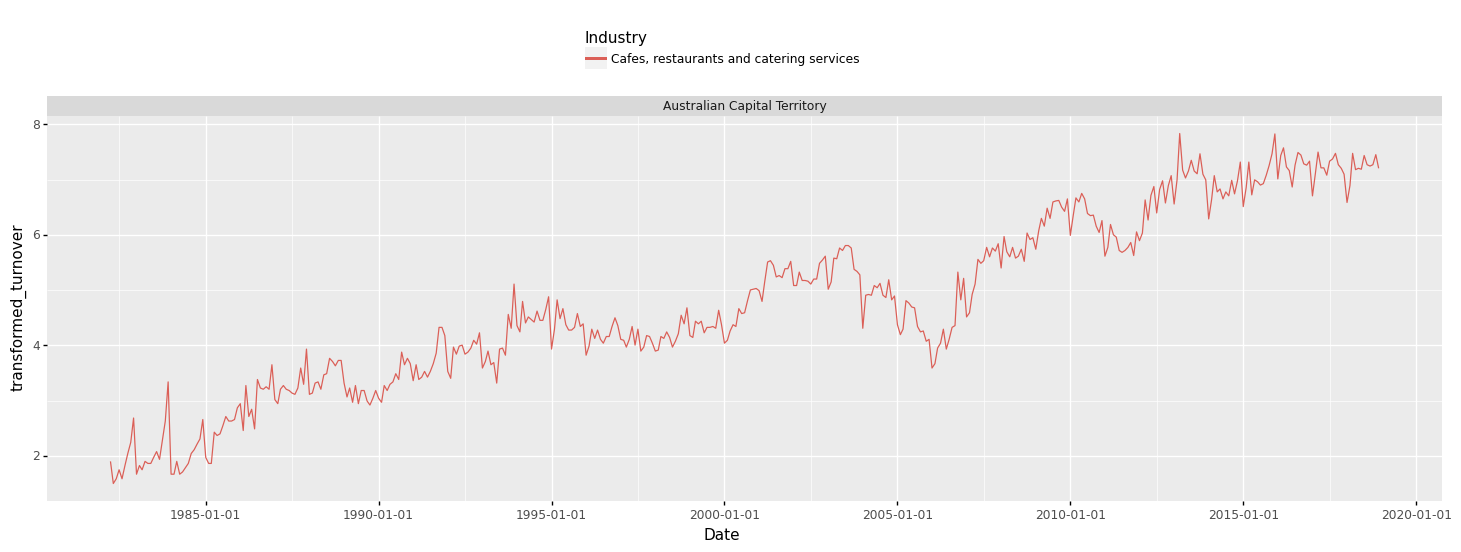

<ggplot: (323797134)>

In [258]:
aus_retail_df = load_data("aus_retail").assign(
    Date=lambda df: pd.to_datetime(df.Month, format="%Y %b")
).assign(
    Year=lambda df: df.Date.dt.year, Month=lambda df: df.Date.dt.month
)

series = aus_retail_df[aus_retail_df["Series ID"] == 'A3349849A'].assign(
    transformed_turnover = lambda df: BoxCox().transform_boxcox(
        x=df.Turnover, method='guerrero'
    )[0]
)
series
(ggplot(series) +
    aes(x='Date', y='transformed_turnover', color='Industry') +
    geom_line() +
    facet_wrap("State") +
    theme(figure_size=(18, 5), legend_position="top")
)

In [251]:
series

,State,Industry,Series ID,Month,Turnover,Date,Year
0,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,4,4.4,1982-04-01,1982
1,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,5,3.4,1982-05-01,1982
2,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,6,3.6,1982-06-01,1982
3,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,7,4.0,1982-07-01,1982
4,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,8,3.6,1982-08-01,1982
...,...,...,...,...,...,...,...
436,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,8,41.7,2018-08-01,2018
437,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,9,41.4,2018-09-01,2018
438,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,10,41.7,2018-10-01,2018
439,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,11,44.0,2018-11-01,2018


4. What Box-Cox transformation would you select for your retail data (from Exercise 8 in Section 2.10)?


- **I don't understand that question, what from which?**
5. For the following series, find an appropriate Box-Cox transformation in order to stabilise the variance. Tobacco from aus_production, Economy class passengers between Melbourne and Sydney from ansett, and Pedestrian counts at Southern Cross Station from pedestrian.

- **I don't understand that question, what does appropriate mean?**

<AxesSubplot:xlabel='Date'>

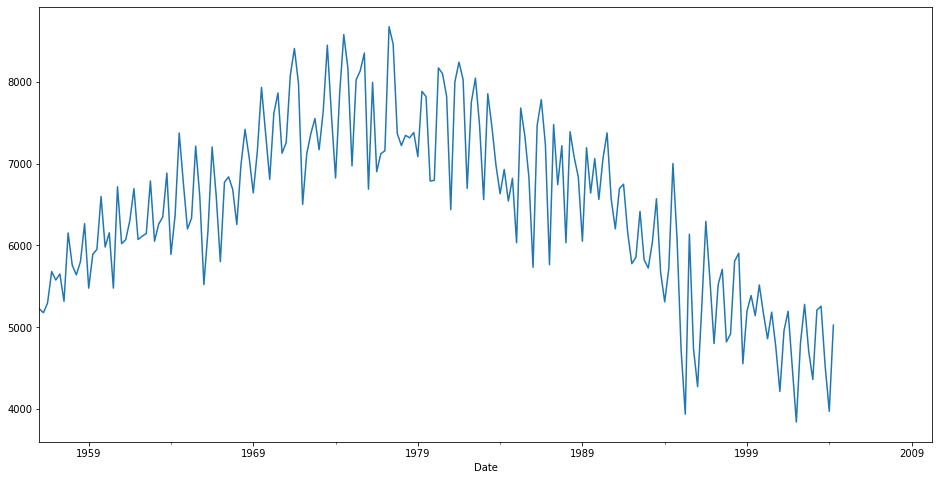

In [264]:
aus_production_df.set_index('Date').Tobacco.plot()

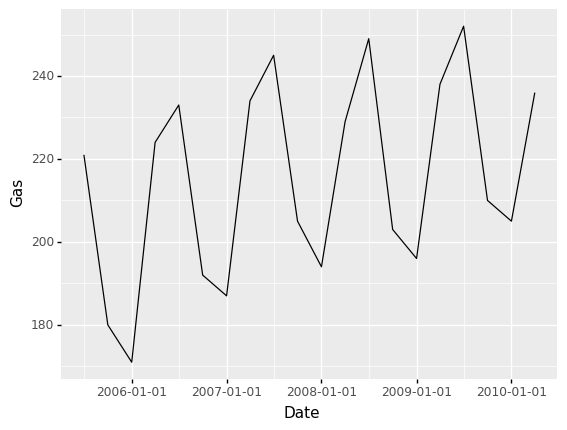

<ggplot: (322160737)>

In [274]:
# 7. 
last_aus_prod = aus_production_df.set_index('Date').tail(5*4)
ggplot(last_aus_prod.reset_index()) + aes(x='Date', y='Gas') + geom_line()

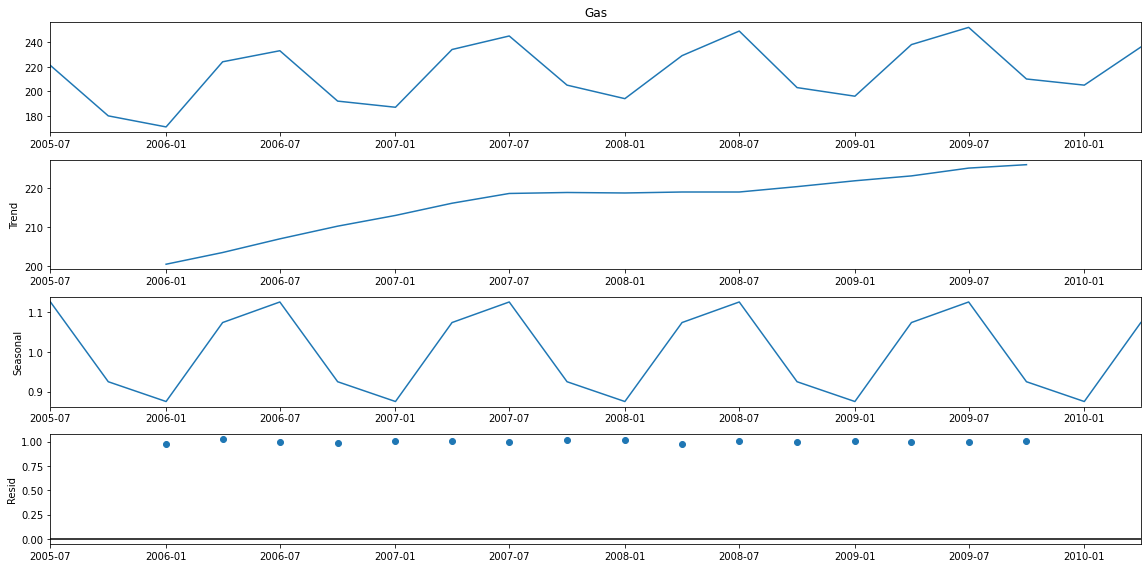

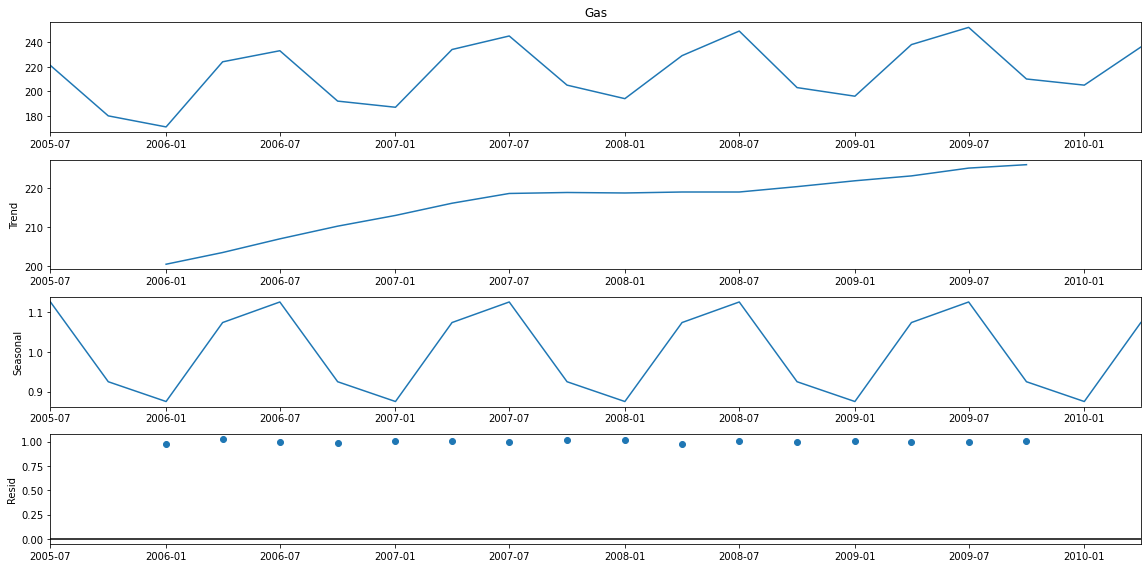

In [282]:


from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(x=last_aus_prod.Gas, model='multiplicative')
res.plot()
# Yes, they support it